# DID analysis about the number of submissions

## Install and import packages

In [1]:
# 必要なパッケージをインストール
%pip install pandas statsmodels matplotlib seaborn scikit-learn

# パッケージの読み込み
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 7.0 MB/s eta 0:00:0000:01:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load data

In [2]:
# Load the two CSV files
file_treatment = "./combined_texts_Palestine_Israel_IsraelPalestine_20241118_151608.csv"
file_control = "./combined_texts_ps4homebrew_Exercise_voyageons_20241118_180836.csv"

# Reading the treatment and control group data
df_treatment = pd.read_csv(file_treatment)
df_control = pd.read_csv(file_control)

# Display basic information about the datasets to understand their structure
df_treatment.info(), df_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261421 entries, 0 to 261420
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         260299 non-null  object
 1   created_utc  261419 non-null  object
dtypes: object(2)
memory usage: 4.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15236 entries, 0 to 15235
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         15084 non-null  object
 1   created_utc  15236 non-null  object
dtypes: object(2)
memory usage: 238.2+ KB


(None, None)

## Sub sampling

In [3]:
# Smallest group size
min_size = min(len(df_treatment), len(df_control))

# Subsample treatment and control groups
df_treatment = resample(df_treatment, n_samples=min_size, random_state=42)
df_control = resample(df_control, n_samples=min_size, random_state=42)

## Grouping data into treatment or control

In [4]:
# Convert 'created_utc' to datetime and create treatment/control dummy variables
df_treatment['created_utc'] = pd.to_datetime(df_treatment['created_utc'], utc=True)
df_control['created_utc'] = pd.to_datetime(df_control['created_utc'], utc=True)

# Add group identifier: 1 for treatment, 0 for control
df_treatment['group'] = 1
df_control['group'] = 0

# Merge both datasets for analysis
df_combined = pd.concat([df_treatment, df_control], ignore_index=True)

# Create a binary variable for pre- and post- October 1, 2024
cutoff_date = pd.to_datetime('2024-10-01', utc=True)
df_combined['post_treatment'] = (df_combined['created_utc'] >= cutoff_date).astype(int)

# Group by day to count number of submissions per day for each group
df_combined['date'] = df_combined['created_utc'].dt.date
daily_counts = df_combined.groupby(['date', 'group', 'post_treatment']).size().reset_index(name='submission_count')

# Display the resulting daily submission counts
daily_counts.head()

,date,group,post_treatment,submission_count
0,2024-07-28,0,0,17
1,2024-07-28,1,0,59
2,2024-07-29,0,0,67
3,2024-07-29,1,0,107
4,2024-07-30,0,0,39


## Create model and output summary

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create the interaction term for DID
daily_counts['interaction'] = daily_counts['group'] * daily_counts['post_treatment']

# Define the DID regression model: submission_count ~ group + post_treatment + interaction
did_model = ols('submission_count ~ group + post_treatment + interaction', data=daily_counts).fit()

# Output the summary of the DID regression results
did_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       submission_count   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.698
Date:                Mon, 18 Nov 2024   Prob (F-statistic):              0.168
Time:                        18:31:39   Log-Likelihood:                -1316.0
No. Observations:                 221   AIC:                             2640.
Df Residuals:                     217   BIC:                             2654.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        143.9231     11.681     12.321      0.000     120.900     166.946
group            -16.4923     16.520     -0.998      0.319     -49.052      16.067
post_treatment   -21.4022     17.923     -1.194      0.234     -56.727      13.923
interaction       55.6691     25.767      2.161      0.032       4.884     106.454
==============================================================================
Omnibus:                       20.354   Durbin-Watson:                   0.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.885
Skew:                           0.049   Prob(JB):                       0.0320
Kurtosis:                       2.141   Cond. No.                         6.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Visualization

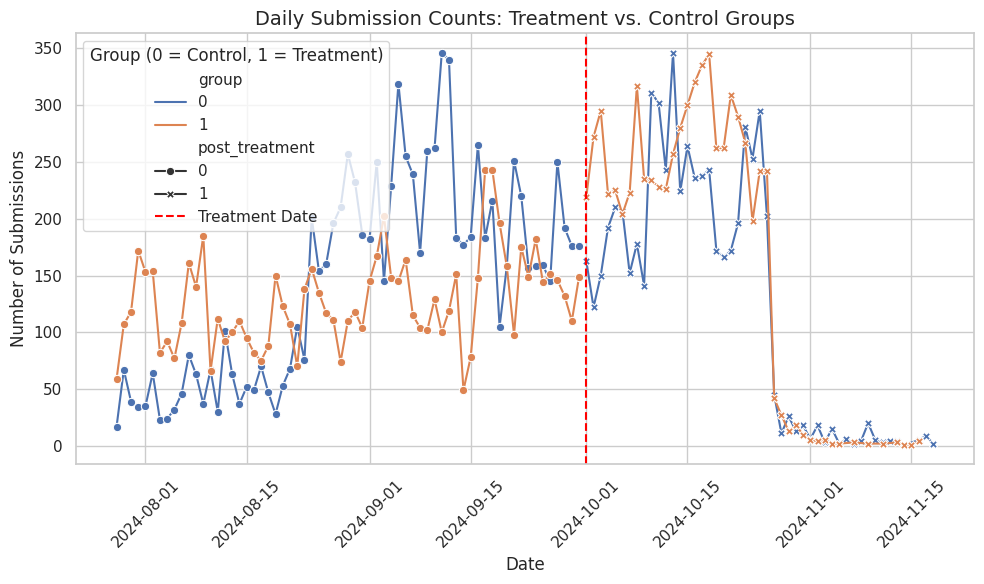

In [6]:
# Set plot style
sns.set(style="whitegrid")

# Plot daily submission counts for treatment and control groups, before and after the treatment date
plt.figure(figsize=(10, 6))

# Plot submission counts over time for treatment and control groups
sns.lineplot(data=daily_counts, x='date', y='submission_count', hue='group', style='post_treatment', markers=True, dashes=False)

# Add vertical line indicating the treatment date
plt.axvline(pd.to_datetime('2024-10-01'), color='red', linestyle='--', label='Treatment Date')

# Labels and title
plt.title('Daily Submission Counts: Treatment vs. Control Groups', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Submissions', fontsize=12)
plt.legend(title='Group (0 = Control, 1 = Treatment)')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()
